In [1]:
import pandas as pd
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv(r'.env')
import os
data_dir = os.environ.get('DATA_DIR')

In [2]:
data = pd.read_csv(data_dir + "/sign_mnist_train.csv")
data.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
data.isna().any().any()

False

In [4]:
def split_dataset(dataset, split_ratio=0.8):
    """Permet de separer les données en jeux d'entrainement et de validation selon un pourcentage pour le jeu d'entrainement"""

    random.shuffle(dataset)

    split_index = int(len(dataset) * split_ratio)

    train_set = dataset[:split_index]
    validation_set = dataset[split_index:]

    return train_set, validation_set


train_set, validation_set = split_dataset(np.array(data), split_ratio=0.8)

#Division des labels et des données
X_train = train_set[:,1:]
y_train = train_set[::,0]
X_val = validation_set[:,1:]
y_val = validation_set[::,0]

In [10]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=15, criterion="entropy")
print(model)

DecisionTreeClassifier(criterion='entropy', max_depth=15)


In [11]:
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [12]:
pred = model.predict(X_val)
(pred == y_val).mean()

0.8978328173374613

### Random forest from scratch

In [5]:
def get_majority_class(labels):
    # return the most common label
    
    counts = Counter(labels)
    return counts.most_common(1)[0][0]


#def compute_entropy(labels):
#    # compute the entropy
#    #= sum_l(-p_l log2 (p_l)) for each label l)
#    # of the input array.
#
#    counts = Counter(labels)
#    counts = np.array([counts[key] for key in counts])
#    freq = counts/counts.sum()
#    entropy = -(freq*np.log2(freq)).sum()
#    return entropy

def compute_entropy(labels):
    value_counts = np.bincount(labels)
    probabilities = value_counts[value_counts > 0] / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


In [6]:
example_labels = np.array([3,1,2,0,2])
print(get_majority_class(example_labels)) # should be 2
print(compute_entropy(example_labels)) # should be 1.9219280948873623

2
1.9219280948873623


In [7]:
class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None
        self.left_child=None
        self.right_child=None

    def find_best_question(self, x, y):
        # x: np array of shape (number of examples, number of features)
        # y: np array of shape (number of examples,)

        best_col = 0
        best_val = 0
        best_loss = np.inf

        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols) # nb of features
        for col in valid_cols:
            # Compute the midpoints of this column's values
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i]+sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1)]

            for val in midpoints:
                # Using col and val, split the labels
                # into left_labels, right_labels here

                right_subset_rows = x[: , col] > val
                left_subset_rows = np.invert(right_subset_rows)

                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]

                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)

                p_right = len(right_labels)/len(y)
                p_left = len(left_labels)/len(y)


                loss =  p_left*left_entropy + p_right*right_entropy


                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue

                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val

        self.col = best_col
        self.threshold = best_val

    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False

    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None

In [8]:

node=Node()
example_x = np.array([[-2.32,  2.02,  0.53,  0.34],
       [-1.44,  1.36,  0.12, -0.44],
       [-0.28, -0.08,  0.9 , -1.63],
       [-0.09,  0.17, -0.28,  0.44],
       [ 0.8 , -1.65,  1.36,  1.62]])
example_y = np.array([3,1,2,0,2])

# Test find_best_question()
node.find_best_question(example_x, example_y)
print(node.threshold) # should be 0.045
print(node.col) # should be 0

# Test ask_question()
test_x = np.array([[ 1.05, -1.85, -2.24,  1.45],
       [ 1.2 , -0.34,  1.54, -0.39]])
print(node.ask_question(test_x)) # should be [False False]

0.045000000000000005
1
[False False]


In [9]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth

    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()

        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)

        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset,y_subset)
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset)
            left_subset_rows = np.invert(right_subset_rows)
            
            # Recursion: create node.left_child and node.right_child 
            node.left_child = self.create_node(x_subset[left_subset_rows],y_subset[left_subset_rows],depth+1) # FILL IN HERE
            node.right_child = self.create_node(x_subset[right_subset_rows],y_subset[right_subset_rows], depth+1) # FILL IN HERE

        return node

    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)

    def predict(self, x):
        predictions = []

        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True

                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)

In [6]:
from collections import Counter
import numpy as np
from scipy.sparse import issparse

class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None
        self.left_child = None
        self.right_child = None

    def find_best_question(self, x, y):
        best_col = 0
        best_val = 0
        best_loss = np.inf

        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols)
        for col in valid_cols:
            if issparse(x):
                col_values = np.unique(x[:, col].data)
            else:
                col_values = np.unique(x[:, col])

            midpoints = (col_values[:-1] + col_values[1:]) / 2

            for val in midpoints:
                right_subset_rows = x[:, col] > val
                left_subset_rows = ~right_subset_rows

                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]

                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)

                p_right = len(right_labels) / len(y)
                p_left = len(left_labels) / len(y)

                loss = p_left * left_entropy + p_right * right_entropy

                if right_labels.shape[0] == 0 or left_labels.shape[0] == 0:
                    continue

                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val

        self.col = best_col
        self.threshold = best_val

    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False

    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None

class DecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth

    def create_node(self, x_subset, y_subset, depth):
        node = Node()

        majority_class = get_majority_class(y_subset)
        majority_class_count = np.sum(y_subset == majority_class)
        perfectly_classified = majority_class_count == len(y_subset)

        if perfectly_classified or depth == self.max_depth:
            node.output_class = majority_class
            node.is_leaf = True
        else:
            node.find_best_question(x_subset, y_subset)
            node.is_leaf = False
            right_subset_rows = node.ask_question(x_subset)
            left_subset_rows = ~right_subset_rows

            node.left_child = self.create_node(x_subset[left_subset_rows], y_subset[left_subset_rows], depth + 1)
            node.right_child = self.create_node(x_subset[right_subset_rows], y_subset[right_subset_rows], depth + 1)

        return node

    def fit(self, x, y):
        if issparse(x):
            x = x.toarray()

        self.root_node = self.create_node(x, y, depth=1)

    def predict(self, x):
        predictions = []

        if issparse(x):
            x = x.toarray()

        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1, -1)
            done_descending_tree = False
            while not done_descending_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_descending_tree = True
                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)


In [7]:
tree = DecisionTreeClassifier(max_depth=6)
tree.fit(X_train, y_train)
print("accuracy: ", (tree.predict(X_val) == y_val).mean() * 100, "%")

accuracy:  28.100528136951375 %


Random forest

In [8]:
import math

class RandomForestClassifier():
    def __init__(self, n_estimators=2, max_depth=5, bootstrap_fraction=0.5, features_fraction=0.5):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.bootstrap_fraction = bootstrap_fraction
        self.features_fraction= features_fraction
        self.estimators = []

    def fit(self, x, y):
        num_rows = math.ceil(self.bootstrap_fraction * x.shape[0])
        num_cols = math.ceil(self.features_fraction * x.shape[1])
        for _ in range(self.n_estimators):
            # Create noisy subsets x_subset, y_subset
            rows_idx = np.random.choice(x.shape[0], size = num_rows) # FILL IN HERE
            cols_idx = np.random.choice(x.shape[1], size = num_cols, replace = False) # FILL IN HERE
            x_subset = x[rows_idx][:, cols_idx]
            y_subset = y[rows_idx]

            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(x_subset, y_subset)
            self.estimators.append((tree,cols_idx))

    def predict(self, x):
        allpreds = np.array([e.predict(x[:,cols]) for e, cols in self.estimators])
        predictions = np.array([get_majority_class(y) for y in allpreds.T])
        return predictions


Best performance:  0.16827535967947552


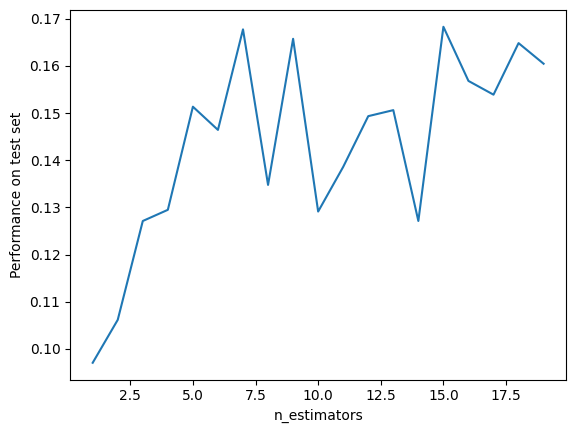

In [12]:
tree_counts = []
accuracies = []
for tree_count in range(1, 20):
    model = RandomForestClassifier(n_estimators=tree_count,
                                   max_depth=3,
                                   bootstrap_fraction=1,
                                   features_fraction=0.5)
    model.fit(X_train[:1000,:], y_train[:1000])
    accuracy = (model.predict(X_val) == y_val).mean()
    accuracies.append(accuracy)
    tree_counts.append(tree_count)

print("Best performance: ", max(accuracies))
plt.xlabel('n_estimators')
plt.ylabel('Performance on test set')
plt.plot(tree_counts, accuracies)
